# HW_2_Javier_Gilabert_Sabater
## Análisis Predictivo

In [105]:
import warnings
warnings.filterwarnings('ignore')

In [106]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [107]:
# Read Data
df = pd.read_csv('StackOverflow.csv')
df.head()

,month,nltk,spacy,stanford-nlp,python,r,numpy,scipy,matlab,machine-learning,...,Plato,Sympy,Flair,stanford-nlp.1,pyqt,Nolearn,Lasagne,OCR,Apache-spark-mlib,azure-virtual-machine
0,09-Jan,0,0,0,631,8,6,2,19,8,...,0,1,0,0,5,0,0,5,0,0
1,09-Feb,1,0,0,633,9,7,3,27,4,...,0,0,0,0,5,0,0,11,0,0
2,09-Mar,0,0,0,766,4,4,2,24,3,...,0,0,0,0,7,0,0,2,0,0
3,09-Apr,0,0,0,768,12,6,3,32,10,...,0,0,0,0,11,0,0,5,0,0
4,09-May,1,0,0,1003,2,7,2,42,7,...,0,0,0,0,10,0,0,3,0,0


## 1. - Analizar los datos de MATLAB, entre otros análisis, se debe graficar la serie, estudiar la estacionalidad y la estacionariedad.

In [108]:
df_matlab  = pd.DataFrame()
df_matlab['date'] = df['month']
df_matlab['matlab'] = df['matlab']
df_matlab

,date,matlab
0,09-Jan,19
1,09-Feb,27
2,09-Mar,24
3,09-Apr,32
4,09-May,42
...,...,...
127,19-Aug,371
128,19-Sep,362
129,19-Oct,523
130,19-Nov,479


In [109]:
df_matlab['date'] = pd.to_datetime(df_matlab['date'], format='%y-%b')
df_matlab = df_matlab.set_index('date')
df_matlab

,matlab
date,
2009-01-01,19
2009-02-01,27
2009-03-01,24
2009-04-01,32
2009-05-01,42
...,...
2019-08-01,371
2019-09-01,362
2019-10-01,523


In [110]:
df_matlab_2 = df_matlab.resample("m").last()

<Axes: xlabel='date'>

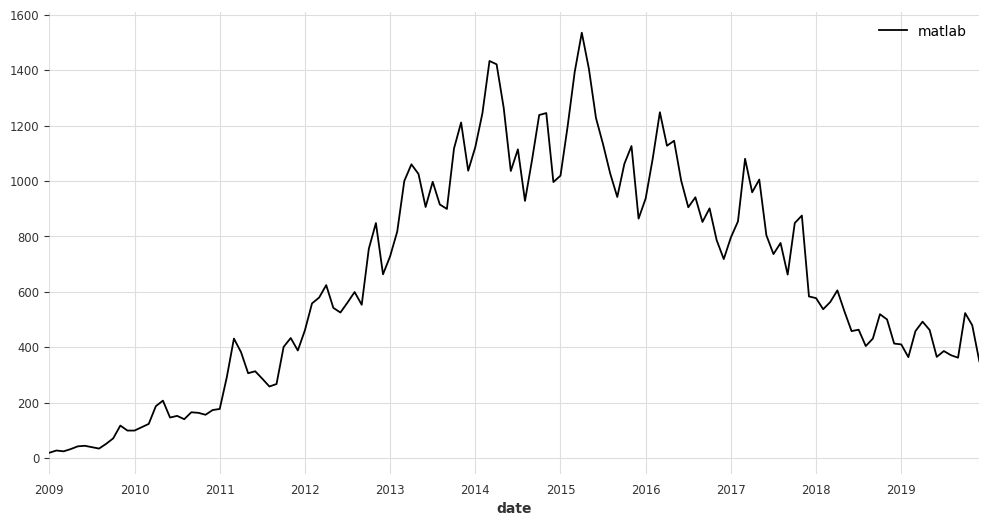

In [111]:
plt.rcParams["figure.figsize"] = (12,6)
df_matlab.plot()

## Estacionalidad

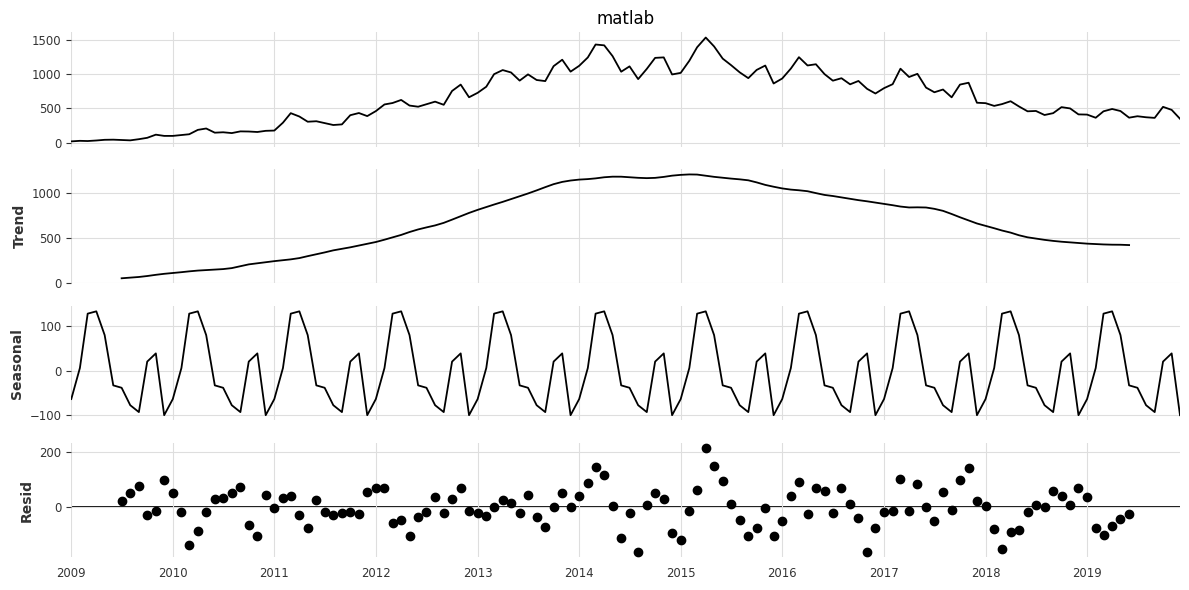

In [112]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df_matlab['matlab'], model='additive', period=12)
result.plot()
plt.show()


Text(0.5, 1.0, 'Comportamiento Estacional')

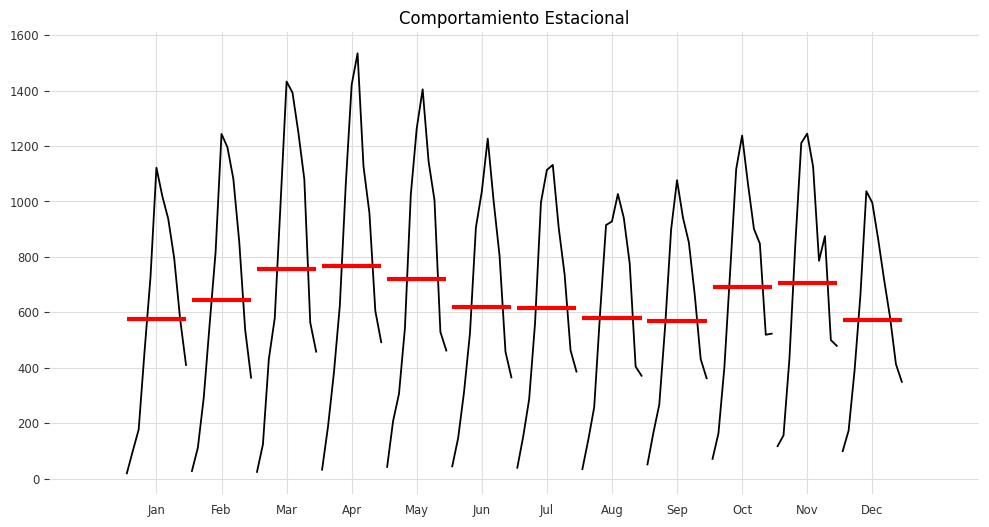

In [113]:
import statsmodels.api as sm
ax = plt.gca()
sm.graphics.tsa.month_plot(df_matlab['matlab'],ax=ax)
ax.set_title('Comportamiento Estacional')

## Estacionariedad

In [114]:
# Log Transformer Function
from sktime.transformations.series.boxcox import LogTransformer

In [115]:
# Apply Log Transformer

transformer = LogTransformer()
log_matlab= transformer.fit_transform(df_matlab)
log_matlab.tail()

,matlab
date,
2019-08-01,5.916202
2019-09-01,5.891644
2019-10-01,6.259581
2019-11-01,6.171701
2019-12-01,5.855072


Text(0.5, 1.0, 'Preguntas sobre matlab: Transformación LOG')

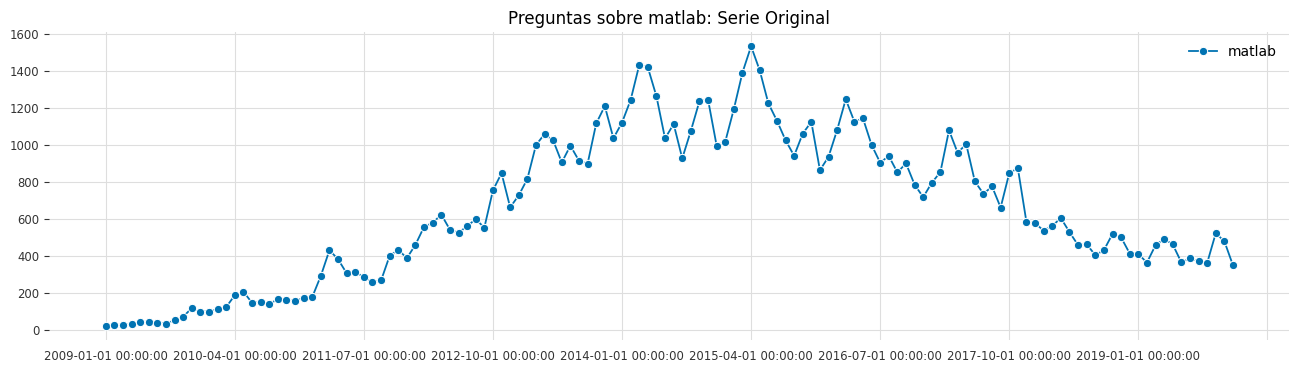

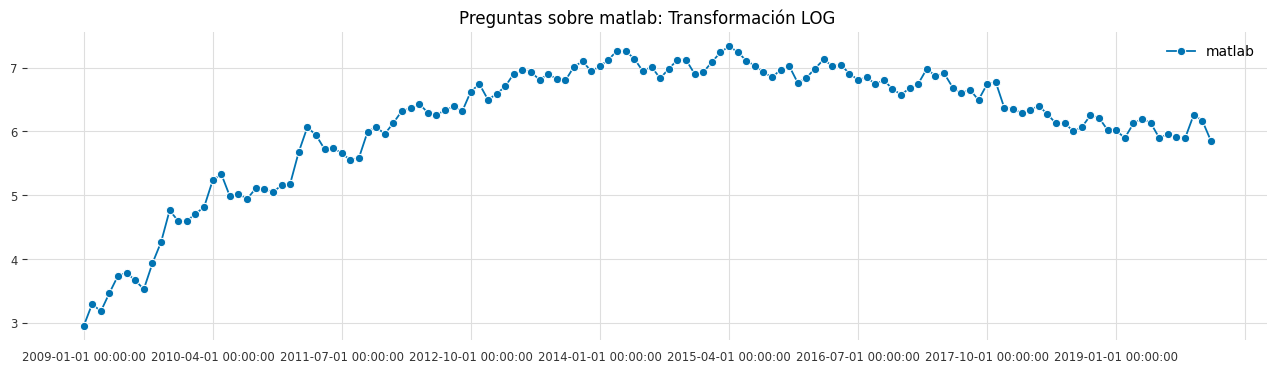

In [116]:
# Plot Log Data
#ax = log_matlab.plot(marker='o', linestyle='-')
#ax.set_ylabel('Preguntas sobre matlab')
#ax.set_title('Preguntas sobre matlab: Transformación LOG')
from sktime.utils.plotting import plot_series
fig, ax =plot_series(df_matlab, labels=["matlab"])
ax.set_title('Preguntas sobre matlab: Serie Original')
fig, ax =plot_series(log_matlab, labels=["matlab"])
ax.set_title('Preguntas sobre matlab: Transformación LOG')

## 2. - Se debe separa la muestra en tres partes entrenamiento, validación(12 meses) y test (6 meses). Cuando no sea necesaria la validación la muestra de test debe ser de 6 meses.

In [117]:

data_train = df_matlab_2['2009-01-01':'2019-01-01']
data_valid = df_matlab_2['2019-01-01':'2019-12-31']
data_test = df_matlab_2['2019-07-01':'2019-12-31']


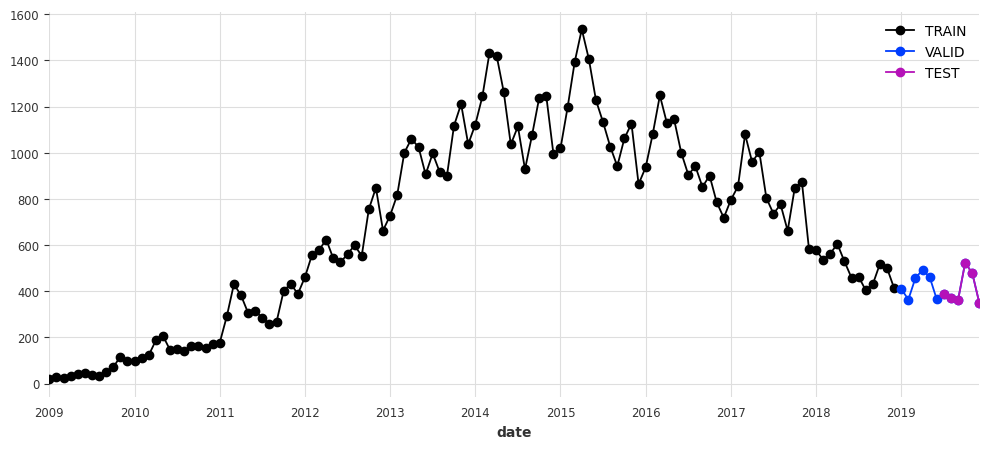

In [118]:
data_train['matlab'].plot(legend=True,label='TRAIN',marker='o')
data_valid['matlab'].plot(legend=True,label='VALID',figsize=(12,5),marker='o');
data_test['matlab'].plot(legend=True,label='TEST',figsize=(12,5),marker='o');

## ETS

In [119]:
from sktime.forecasting.ets import AutoETS

In [120]:
# step 2: specifying forecasting horizon
fh = np.arange(1, 13)

# step 3: specifying the forecasting algorithm
matlab_auto_model = AutoETS(auto=True, sp=4, n_jobs=-1)


In [121]:
matlab_auto_model.fit(data_train)

AutoETS(auto=True, n_jobs=-1, sp=4)

In [122]:
# step 5: querying predictions
matlab_ets_pred = matlab_auto_model.predict(fh)
print(matlab_ets_pred)

                matlab
2019-01-31  412.582927
2019-02-28  449.855996
2019-03-31  476.341624
2019-04-30  446.815620
2019-05-31  445.681164
2019-06-30  485.234814
2019-07-31  513.081058
2019-08-31  480.625831
2019-09-30  478.779402
2019-10-31  520.613633
2019-11-30  549.820492
2019-12-31  514.436042


In [123]:
matlab_pred_ints = matlab_auto_model.predict_interval(fh, coverage=0.9)

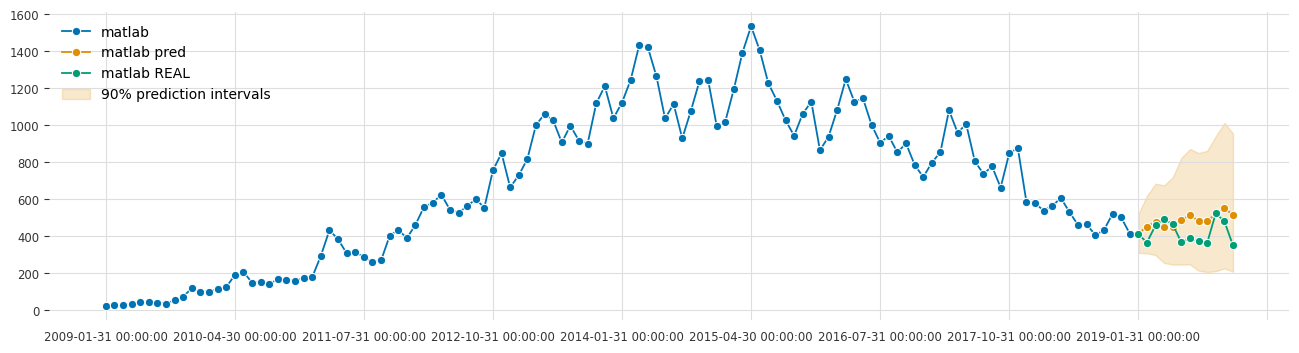

In [124]:
fig, ax = plot_series(data_train, matlab_ets_pred, data_valid, labels=["matlab", "matlab pred", "matlab REAL"])
ax.fill_between(
    ax.get_lines()[-2].get_xdata(),
    matlab_pred_ints[(0, 0.9, 'lower')],
    matlab_pred_ints[(0, 0.9, 'upper')],
    alpha=0.2,
    color=ax.get_lines()[-2].get_c(),
    label=f"90% prediction intervals",
)
ax.legend(loc='upper left')

In [125]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
mean_absolute_percentage_error(data_valid, matlab_ets_pred)

0.19271135425241856

## ARIMA

In [126]:
from sktime.forecasting.arima import AutoARIMA

In [127]:
forecaster = AutoARIMA(sp=12,suppress_warnings=True, trace = True)
forecaster.fit(data_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=1435.455, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=1449.561, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=1451.852, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=1451.706, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=1447.679, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[4] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(2,1,2)(1,0,0)[4] intercept   : AIC=1433.627, Time=0.36 sec
 ARIMA(2,1,2)(0,0,0)[4] intercept   : AIC=1431.433, Time=0.27 sec
 ARIMA(1,1,2)(0,0,0)[4] intercept   : AIC=1446.236, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[4] intercept   : AIC=1444.958, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[4] intercept   : AIC=1433.505, Time=0.29 sec
 ARIMA(2,1,3)(0,0,0)[4] intercept   : AIC=1434.781, Time=0.38 sec
 ARIMA(1,1,1)(0,0,0)[4] intercept   : AIC=1450.474, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[4] intercept   : AIC=1447.825, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[4] intercept   : 

AutoARIMA(sp=4, suppress_warnings=True, trace=True)

In [128]:
matlab_arima_pred = forecaster.predict(fh)
matlab_arima_pred

,matlab
2019-01-31,359.084766
2019-02-28,364.778717
2019-03-31,427.511073
2019-04-30,489.931060
2019-05-31,495.823093
2019-06-30,444.116887
2019-07-31,389.113197
2019-08-31,387.491287
2019-09-30,443.802037
2019-10-31,506.853212


In [129]:
mean_absolute_percentage_error(data_valid, matlab_arima_pred)

0.10342851009858785

## 4Theta

In [130]:
from darts.models import FourTheta
from darts.metrics import mape
from darts.utils.utils import SeasonalityMode, TrendMode, ModelMode
from darts import TimeSeries

In [131]:
df_matlab_2

,matlab
date,
2009-01-31,19
2009-02-28,27
2009-03-31,24
2009-04-30,32
2009-05-31,42
...,...
2019-08-31,371
2019-09-30,362
2019-10-31,523


In [132]:
df_matlab_theta = df_matlab_2.copy()
df_matlab_theta.reset_index(level=0, inplace=True)

df_matlab_ts = TimeSeries.from_dataframe(df_matlab_theta,'date','matlab')
train, test = df_matlab_ts.split_before(pd.Timestamp("20190701"))

In [133]:
model_4theta =FourTheta(seasonality_period=12)
model_4theta.fit(train)
matlab_4theta_pred = model_4theta.predict(len(test))
print("model {} obtains MAPE: {:.2f}%".format(model_4theta, mape(test, matlab_4theta_pred)))

model FourTheta(seasonality_period=12) obtains MAPE: 41.10%


Text(0.5, 1.0, 'model 4Theta')

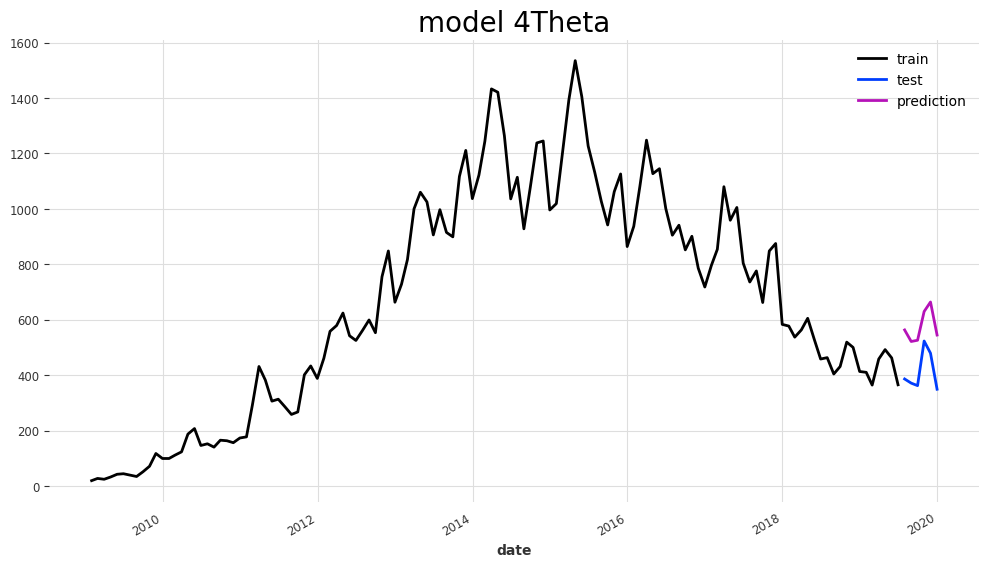

In [134]:
train.plot(label="train")
test.plot(label="test")
matlab_4theta_pred.plot(label="prediction")

plt.title(label="model 4Theta",
          fontsize=20,
          color="black")

In [135]:
fourtheta_grid = {
    'theta':[-4,-3,-2,-1,1,2,3,4],
    'model_mode': [ModelMode.ADDITIVE,ModelMode.MULTIPLICATIVE],
    'season_mode': [SeasonalityMode.MULTIPLICATIVE,SeasonalityMode.ADDITIVE],
    'trend_mode': [TrendMode.EXPONENTIAL,TrendMode.LINEAR]
}

best_grid_model=FourTheta.gridsearch(parameters=fourtheta_grid,
                                series=train,
                                forecast_horizon=36, # 12
                                start=0.5,
                                last_points_only=False,
                                metric=mape,
                                reduction=np.mean,
                                verbose=False,
                                n_jobs=-1)

best_grid_model

Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additiv

(FourTheta(theta=1, seasonality_period=None, season_mode=SeasonalityMode.MULTIPLICATIVE, model_mode=ModelMode.ADDITIVE, trend_mode=TrendMode.EXPONENTIAL, normalization=True),
 {'theta': 1,
  'model_mode': <ModelMode.ADDITIVE: 'additive'>,
  'season_mode': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>,
  'trend_mode': <TrendMode.EXPONENTIAL: 'exponential'>},
 44.399022105125766)

Text(0.5, 1.0, 'Best 4Theta model')

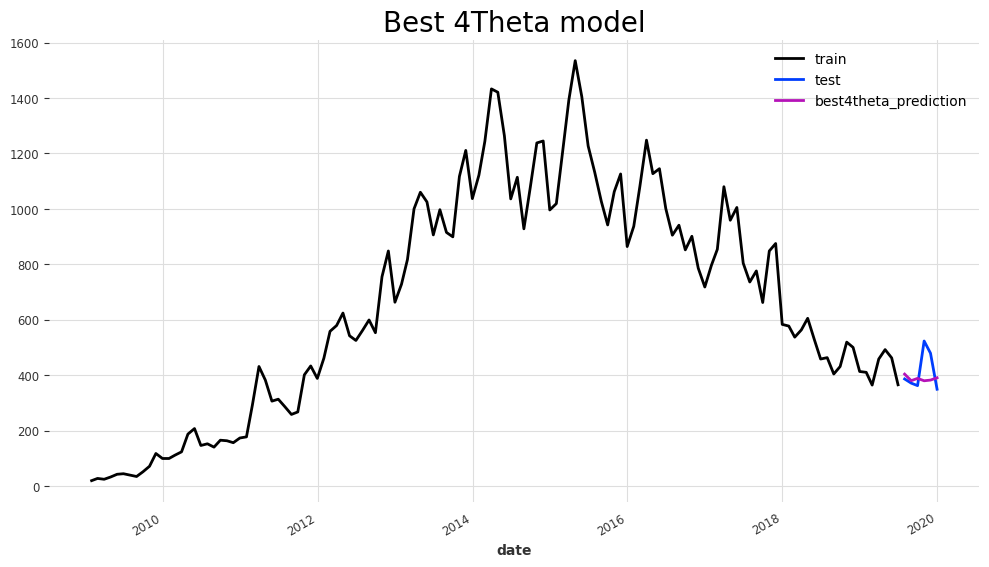

In [136]:
best4Theta_model=FourTheta(theta=best_grid_model[1]['theta'],
                 model_mode=ModelMode.ADDITIVE,
                 season_mode=SeasonalityMode.MULTIPLICATIVE,
                 trend_mode=TrendMode.LINEAR
                 )
best4Theta_model.fit(train)
best4Theta_model_prediction = best4Theta_model.predict(len(test))

train.plot(label="train")
test.plot(label="test")
best4Theta_model_prediction.plot(label="best4theta_prediction")

plt.title(label="Best 4Theta model",
          fontsize=20,
          color="black")

In [137]:
mape(test, best4Theta_model_prediction)

12.279260550010159

## TBATS

In [138]:
from darts.models import TBATS

In [139]:
tbats_model =TBATS(
use_box_cox=None,
box_cox_bounds=(0, 1),
use_trend=None,
use_damped_trend=None,
seasonal_periods="freq",
use_arma_errors=True,
show_warnings=False,
multiprocessing_start_method='spawn',
random_state=0)
tbats_model.fit(train)
tbats_prediction = tbats_model.predict(len(test))

In [140]:
tbats_model.model.params.summary()

'Use Box-Cox: True\nUse trend: True\nUse damped trend: False\nSeasonal periods: [12.]\nSeasonal harmonics [4]\nARMA errors (p, q): (0, 0)\nBox-Cox Lambda 0.575624\nSmoothing (Alpha): 0.731800\nTrend (Beta): 0.041770\nDamping Parameter (Phi): 1.000000\nSeasonal Parameters (Gamma): [ 1.31516020e-07 -3.15248939e-07]\nAR coefficients []\nMA coefficients []\nSeed vector [ 3.62023513  1.87152987  1.10672604 -4.22303091 -1.89909995  0.80224378\n  4.20342617 -0.51672321  0.67266762  1.30258307]\n'

<Axes: xlabel='date'>

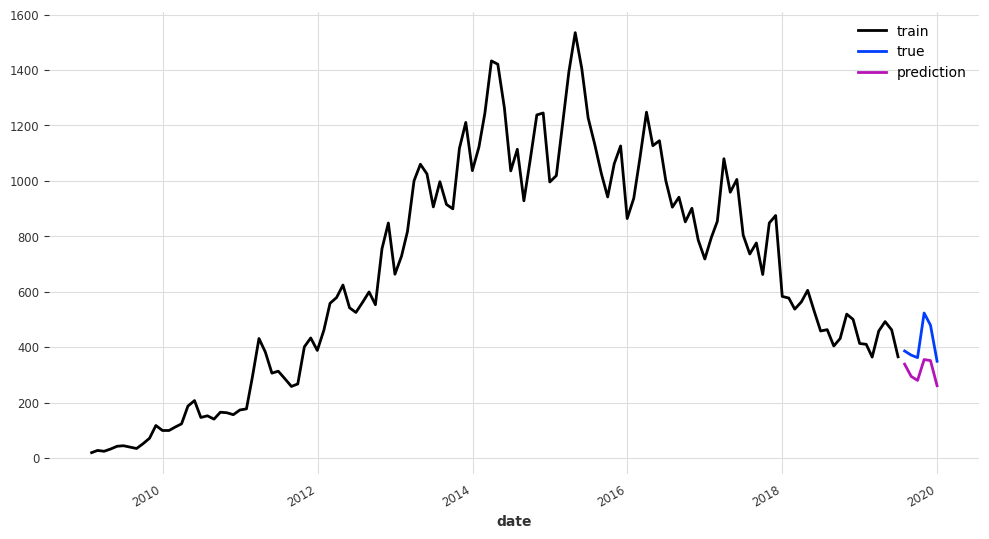

In [141]:
train.plot(label="train")
test.plot(label="true")
tbats_prediction.plot(label="prediction")

In [142]:
mape(test, tbats_prediction)

23.30709181640146

## 3. - Una vez seleccionado el modelo se debe realizar una predicción de 12 meses fuera de la muestra.

In [143]:
ets = mean_absolute_percentage_error(data_valid, matlab_ets_pred)

In [144]:
arima = mean_absolute_percentage_error(data_valid, matlab_arima_pred)

In [145]:
best4Theta = mape(test, best4Theta_model_prediction)

In [146]:
tbats = mape(test, tbats_prediction)

In [148]:
mape = pd.DataFrame()
mape['Modelo'] = ['ETS','ARIMA','4Theta','TBATS']
mape['MAPE'] = [ets, arima, best4Theta, tbats]
mape.sort_values('MAPE')

,Modelo,MAPE
1,ARIMA,0.103429
0,ETS,0.192711
2,4Theta,12.279261
3,TBATS,23.307092


## ARIMA 2

In [149]:
forecaster = AutoARIMA(sp=12,suppress_warnings=True, trace = True)
forecaster.fit(data_train)

Performing stepwise search to minimize aic


 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1395.737, Time=0.78 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1449.561, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1395.156, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1415.067, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1447.679, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1451.217, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=1393.336, Time=0.48 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=1394.942, Time=0.92 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=1392.944, Time=0.31 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1415.076, Time=0.12 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=1394.941, Time=0.69 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=1405.977, Time=0.29 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.19 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1392.921, Time=0.20 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1413.091, Time=0.09 sec


AutoARIMA(sp=12, suppress_warnings=True, trace=True)

In [150]:
matlab_arima_pred = forecaster.predict(fh)
matlab_arima_pred

,matlab
2019-01-31,414.222408
2019-02-28,414.231136
2019-03-31,472.843171
2019-04-30,471.062403
2019-05-31,439.757756
2019-06-30,364.694344
2019-07-31,351.333252
2019-08-31,328.330792
2019-09-30,319.164173
2019-10-31,394.615708


In [151]:
mean_absolute_percentage_error(data_valid, matlab_arima_pred)

0.10022529812263638